# Приоритизация гипотез и анализ А/В - теста

Есть список гипотез для увеличения выручки.В ходе проекта необходимо приоритизировать гипотезы, запустить A/B-тест и проанализировать результаты. Мы имеем 3 таблицы, в которых сохранены такие данные, как:

**Таблица с гипотезами**
- Hypothesis — краткое описание гипотезы;
- Reach — охват пользователей по 10-балльной шкале;
- Impact — влияние на пользователей по 10-балльной шкале;
- Confidence — уверенность в гипотезе по 10-балльной шкале;
- Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы

**Таблица с заказами**
- transactionId — идентификатор заказа;
- visitorId — идентификатор пользователя, совершившего заказ;
- date — дата, когда был совершён заказ;
- revenue — выручка заказа;
- group — группа A/B-теста, в которую попал заказ.

**Таблица с пользователями**
- date — дата;
- group — группа A/B-теста;
- visitors — количество пользователей в указанную дату в указанной группе A/B-теста



##  Загрузка данных и подготовка их к анализу

In [1]:
#импортируем все необходимые нам библтотеки
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy.stats as stats
from scipy import stats as st
import math

In [2]:
#читаем файлы и присваиваем переменные
data = pd.read_csv('/datasets/hypothesis.csv',sep=',')
orders = pd.read_csv('/datasets/orders.csv')
visitors = pd.read_csv('/datasets/visitors.csv')

In [3]:
#изучим подробно каждый датасет
pd.set_option('display.max_colwidth', -1)
data

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


In [4]:
#приведем названия столбцов к общему регистру
data.columns = data.columns.str.lower()

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
hypothesis    9 non-null object
reach         9 non-null int64
impact        9 non-null int64
confidence    9 non-null int64
efforts       9 non-null int64
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


In [6]:
orders.sample(10)

,transactionId,visitorId,date,revenue,group
73,1295850747,2947100995,2019-08-01,29499,A
1013,83566152,232979603,2019-08-31,60,A
764,2176732109,705680638,2019-08-07,1149,A
906,3910266759,789265206,2019-08-10,2590,A
1119,3198443301,3409596883,2019-08-13,2752,A
1010,2211880073,3612778094,2019-08-31,3490,A
987,287313500,172218683,2019-08-10,1440,B
748,434147256,2396134342,2019-08-20,690,B
466,3900869207,656974993,2019-08-26,2840,B
411,1696190144,1687240555,2019-08-06,24744,B


In [7]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
transactionId    1197 non-null int64
visitorId        1197 non-null int64
date             1197 non-null object
revenue          1197 non-null int64
group            1197 non-null object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


In [8]:
#приведем названия столбцов к общему регистру
orders.columns = orders.columns.str.lower()

In [9]:
#приведем дату к нормальному формату
orders['date'] = pd.to_datetime(orders['date'])

In [10]:
#Пропусков у нас нет изначально, проверим на дубли
orders.duplicated().sum()

0

In [11]:
visitors.sample(10)

,date,group,visitors
34,2019-08-04,B,770
11,2019-08-12,A,595
26,2019-08-27,A,711
29,2019-08-30,A,490
38,2019-08-08,B,654
31,2019-08-01,B,713
48,2019-08-18,B,737
59,2019-08-29,B,531
37,2019-08-07,B,709
9,2019-08-10,A,406


In [12]:
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
date        62 non-null object
group       62 non-null object
visitors    62 non-null int64
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


In [13]:
#приведем дату к нормальному формату
visitors['date'] = pd.to_datetime(visitors['date'])

In [14]:
#Пропусков у нас нет изначально, проверим на дубли
visitors.duplicated().sum()

0

**Вывод**

Данные изучены и обработаны, в целом, качественные данные, пропуски отсутствуют, дубликаты и мусор тоже. Привели названия столбцов к одному регистру, изменили формат дат.

## Приоритизация гипотез

**Задачи:**

- Применить фреймворк ICE для приоритизации гипотез. Отсортировать их по убыванию приоритета.
- Применить фреймворк RICE для приоритизации гипотез. Отсортировать их по убыванию приоритета.
- Укажить, как изменилась приоритизация гипотез при применении RICE вместо ICE. Объяснить, почему так произошло.

ICE (от англ. impact, confidence, effort / ease «влияние, уверенность, усилия / простота») — один из самых популярных способов приоритизации задач.

In [15]:
data['ICE'] = (data['impact']*data['confidence']/data['efforts']).round(2)


In [16]:
data.sort_values(by='ICE', ascending = False)

,hypothesis,reach,impact,confidence,efforts,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.20
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.33
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.20
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.33
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.12
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.00


При применении фреймворка ICE, Наиболее перспективные гипотезы 8, 0 и 7. 5,3 и 4 имеют наименьший приоритет.

In [17]:
data['RICE'] = data['reach']*data['impact']*data['confidence']/data['efforts']

In [18]:
data.sort_values(by='RICE', ascending = False)

,hypothesis,reach,impact,confidence,efforts,ICE,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.20,112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.00,56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.33,40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.00,40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.20,16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.12,9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.00,4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.33,4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.00,3.0


По оценке RICE, наиболее перспективные гипотеза 7. 2,0 и 6 также имеют высокий приоритет, но ниже 7. и 1,5 и 4 и 3 самый наименьший.

При применении RICE, приоритизация изменилась за счет количества пользователей, которых затронет изменение. То есть, если по ICE мы имели самый высокий приоритет 8 гипотезы, но при этом оценка REACH 1, когда у 7 максимальная 10. 7 и 0 гипотеза имеют высокие приоритеты по 2м показателям.При этом, 3, 4 и 5 по 2м оценкам не имеют высокий приоритет.

## Анализ А/В-теста

**Задачи:**

Проанализировать A/B-тест:
- Построить график кумулятивной выручки по группам. Сделать выводы и предположения.
- Построить график кумулятивного среднего чека по группам. Сделать выводы и предположения.
- Построить график относительного изменения кумулятивного среднего чека группы B к группе A. Сделать выводы и предположения.
- Построить график кумулятивной конверсии по группам. Сделайть выводы и предположения.
- Построить график относительного изменения кумулятивной конверсии группы B к группе A. Сделайть выводы и предположения.
- Построить точечный график количества заказов по пользователям. Сделайте выводы и предположения.
- Посчитать 95-й и 99-й перцентили количества заказов на пользователя. Выбрать границу для определения аномальных пользователей.
- Построить точечный график стоимостей заказов. Сделайть выводы и предположения.
- Посчитать 95-й и 99-й перцентили стоимости заказов. Выбрать границу для определения аномальных заказов.
- Посчитать статистическую значимость различий в конверсии между группами по «сырым» данным. Сделать выводы и предположения.
- Посчитать статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным. Сделать выводы и предположения.
- Посчитать статистическую значимость различий в конверсии между группами по «очищенным» данным. Сделать выводы и предположения.
- Посчитать статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным. Сделать выводы и предположения.
- Принять решение по результатам теста и объяснить его. Варианты решений: 1. Остановить тест, зафиксировать победу одной из групп. 2. Остановить тест, зафиксировать отсутствие различий между группами. 3. Продолжить тест.

In [19]:
#Создадим массив уникальных пар значений дат и групп теста методом drop_duplicates():
datesGroups = orders[['date','group']].drop_duplicates() 

In [20]:
#Агрегируем значения. Вычислим максимальную дату.Найдём число уникальных ID заказов и пользователей. 
#Подсчитаем сумму средних чеков:
ordersAggregated = datesGroups.apply(
lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])].agg({
'date' : 'max',
'group' : 'max',
'transactionid' : pd.Series.nunique,
'visitorid' : pd.Series.nunique,
'revenue' : 'sum'}), axis=1).sort_values(by=['date','group'])

In [21]:
#Аналогично получим агрегированные кумулятивные по дням данные о посетителях интернет-магазина:
visitorsAggregated = datesGroups.apply(
lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])].agg({
'date' : 'max',
'group' : 'max',
'visitors' : 'sum'}), axis=1).sort_values(by=['date','group']) 

In [22]:
#Объединим обе таблицы в одной с понятными названиями столбцов:
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

In [23]:
cumulativeData.head()

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,24,20,148579,719
1,2019-08-01,B,21,20,101217,713
2,2019-08-02,A,44,38,242401,1338
3,2019-08-02,B,45,43,266748,1294
4,2019-08-03,A,68,62,354874,1845


In [24]:
#Объявим переменные cumulativeRevenueA и cumulativeRevenueB, в которых сохраним
#данные о датах, выручке и числе заказов в группах A и B.
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

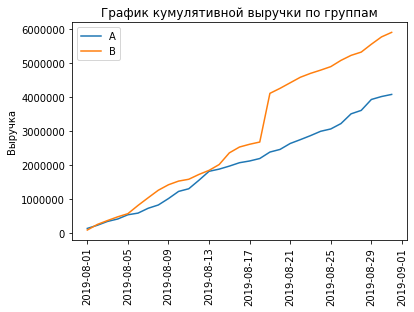

In [25]:
#Построим графики кумулятивной выручки по дням по группам.
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')
plt.xticks(rotation=90)
plt.ylabel("Выручка")
plt.title('График кумулятивной выручки по группам')
plt.legend();

Выручка почти равномерно увеличивается в течении всего теста. Однако, есть некоторые точки, в которых выручка резко растет - это может быть связано со всплеском заказов или очень крупными чеками. Также Тест В практически сразу  занял лидирующие позиции, а чуть ближе к середине теста вырвался вперед с большим отрывом.

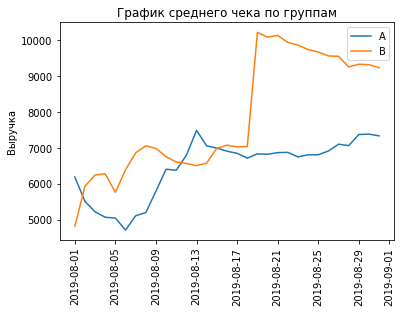

In [26]:
#Построим графики среднего чека по группам — разделим кумулятивную выручку на кумулятивное число заказов:
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
plt.xticks(rotation=90)
plt.ylabel("Выручка")
plt.title('График среднего чека по группам')
plt.legend();

Средний чек группы А выравнился к середине теста, а чек группы В имеет сильный всплеск и потом продолжает равномерно падать. Возможно также влияние крупных заказов.

In [27]:
#Построим график относительного различия для среднего чека
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, 
left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

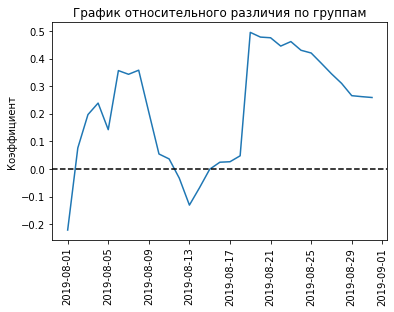

In [28]:
# cтроим отношение средних чеков
plt.plot(mergedCumulativeRevenue['date'], 
(mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])
         /(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)
# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--')
plt.xticks(rotation=90)
plt.ylabel("Коэффициент")
plt.title('График относительного различия по группам');


В своем большинстве график значения сегментов имеет существенные различия. Предполагаю, что вы имеем дело с "выбросами" и аномальными заказами

In [29]:
#Аналогично проанализируем график кумулятивной конверсии
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

In [30]:
# отделяем данные по группе A
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

In [31]:
# отделяем данные по группе B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

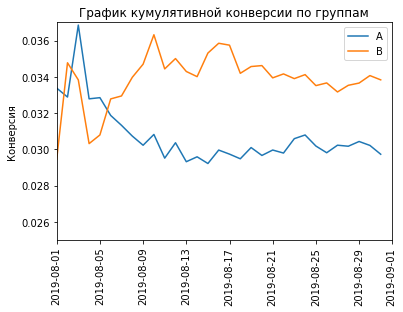

In [32]:
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.legend()
plt.title('График кумулятивной конверсии по группам')
plt.xticks(rotation=90)
plt.ylabel("Конверсия")
# задаем масштаб осей
plt.axis(["2019-08-01", '2019-09-01', 0.025, 0.037]);

Сначала сегмент А имел более высокую конверсию, но имеет отрицательную динамику, когда сергент В наоборот, положительную. Тем самым В постепенно обогнал А. Конверсия колеблется в пределах 1%.

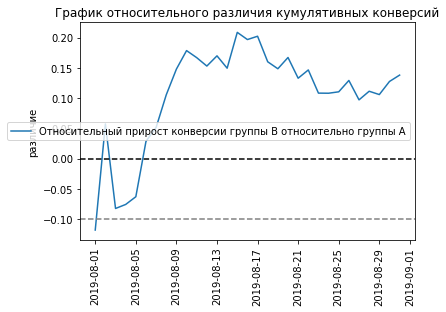

In [33]:
#Построим график относительного различия кумулятивных конверсий
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].\
merge(cumulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB']\
         /mergedCumulativeConversions['conversionA']-1, label="Относительный прирост конверсии группы B относительно группы A")
plt.legend()
plt.xticks(rotation=90)
plt.ylabel("различие")

plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=-0.1, color='grey', linestyle='--')
plt.title('График относительного различия кумулятивных конверсий');

Группа В практически сразу вырвалась вперед и держит эти позиции

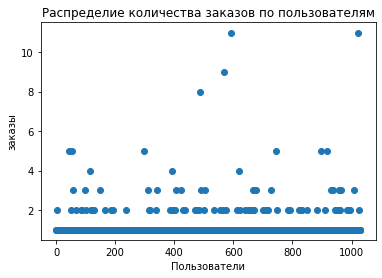

In [34]:
#Построим точечный график количества заказов по пользователям. Посчитаем количество заказов по пользователям
ordersByUsers = (
    orders.drop(['group', 'revenue', 'date'], axis=1)
    .groupby('visitorid', as_index=False)
    .agg({'transactionid': pd.Series.nunique})
)

ordersByUsers.columns = ['userId', 'orders']
x_values = pd.Series(range(0,len(ordersByUsers)))

plt.scatter(x_values, ordersByUsers['orders']) 
plt.xlabel('Пользователи')
plt.ylabel("заказы")
plt.title('Распределие количества заказов по пользователям');

Большинство пользователей имеют до 3 заказов, но мы видим такие выбросы, как 8, 10 и более заказов

In [35]:
#Посчитаем выборочные перцентили количества заказов на одного пользователя:
print(np.percentile(ordersByUsers['orders'], [95, 99])) 

[2. 4.]


Не более 5% заказывали больше 2х раз и менее 1% имеют заказы, больше 4. Все, что свыше 4 заказов ( 1% пользователей) примем за аномальные значения.

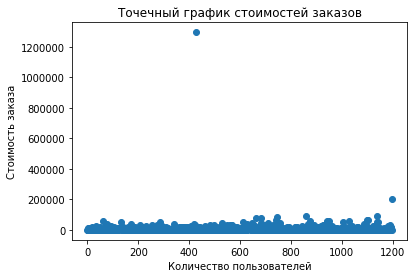

In [36]:
#Построим точечный график стоимостей заказов
x_values = pd.Series(range(0,len(orders['revenue'])))
plt.scatter(x_values, orders['revenue']) 
plt.xlabel('Количество пользователей')
plt.ylabel("Cтоимость заказа")
plt.title('Точечный график стоимостей заказов');

Как мы видим, все заказы до 200000, но есть пару выбросов, в 6 раз превышающие норму

In [37]:
#Посчитаем 95-й и 99-й перцентили стоимости заказов
np.percentile(orders['revenue'], [95, 99])

array([28000. , 58233.2])

5% превышают стоимость, выше 28000, а 1 % свыше 58233. Установим значения, свыше 99 перцентиля, как выбросы.

Посчитаем статистическую значимость различий в конверсии и среднем чеке между группами по «сырым» данным .Начнём с подготовки

In [38]:
visitorsADaily = visitors[visitors['group']=='A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsACummulative = visitorsADaily.apply(lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg({'date' : 'max', 'visitorsPerDateA' : 'sum'}), axis=1)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

visitorsBDaily = visitors[visitors['group']=='B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCummulative = visitorsBDaily.apply(lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg({'date' : 'max', 'visitorsPerDateB' : 'sum'}), axis=1)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

ordersADaily = orders[orders['group']=='A'][['date', 'transactionid', 'visitorid', 'revenue']]\
    .groupby('date', as_index=False)\
    .agg({'transactionid' : pd.Series.nunique, 'revenue' : 'sum'})
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACummulative = ordersADaily.apply(
    lambda x: \
        ordersADaily[ordersADaily['date'] <= x['date']]\
            .agg({
                'date' : 'max',
                'ordersPerDateA' : 'sum',
                'revenuePerDateA' : 'sum'}), axis=1).sort_values(by=['date'])
ordersACummulative.columns = ['date', 'ordersCummulativeA', 'revenueCummulativeA']

ordersBDaily = orders[orders['group']=='B'][['date', 'transactionid', 'visitorid', 'revenue']]\
    .groupby('date', as_index=False)\
    .agg({'transactionid' : pd.Series.nunique, 'revenue' : 'sum'})
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = ordersBDaily.apply(
    lambda x: \
        ordersBDaily[ordersBDaily['date'] <= x['date']]\
            .agg({
                'date' : 'max',
                'ordersPerDateB' : 'sum',
                'revenuePerDateB' : 'sum'}), axis=1).sort_values(by=['date'])
ordersBCummulative.columns = ['date', 'ordersCummulativeB', 'revenueCummulativeB']

data = ordersADaily.merge(ordersBDaily, left_on='date', right_on='date', how='left')\
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')\
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')\
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')\
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')\
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')\
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')

In [39]:
data.head()

,date,ordersPerDateA,revenuePerDateA,ordersPerDateB,revenuePerDateB,ordersCummulativeA,revenueCummulativeA,ordersCummulativeB,revenueCummulativeB,visitorsPerDateA,visitorsPerDateB,visitorsCummulativeA,visitorsCummulativeB
0,2019-08-01,24,148579,21,101217,24,148579,21,101217,719,713,719,713
1,2019-08-02,20,93822,24,165531,44,242401,45,266748,619,581,1338,1294
2,2019-08-03,24,112473,16,114248,68,354874,61,380996,507,509,1845,1803
3,2019-08-04,16,70825,17,108571,84,425699,78,489567,717,770,2562,2573
4,2019-08-05,25,124218,23,92428,109,549917,101,581995,756,707,3318,3280


Названия столбцов:
- date — дата;
- ordersPerDateA — количество заказов в выбранную дату в группе A;
- revenuePerDateA — суммарная выручка в выбранную дату в группе A;
- ordersPerDateB — количество заказов в выбранную дату в группе B;
- revenuePerDateB — суммарная выручка в выбранную дату в группе B;
- ordersCummulativeA — суммарное число заказов до выбранной даты включительно в группе A;
- revenueCummulativeA суммарная выручка до выбранной даты включительно в группе A;
- ordersCummulativeB — суммарное количество заказов до выбранной даты включительно в группе B;
- revenueCummulativeB — суммарная выручка до выбранной даты включительно в группе B;
- visitorsPerDateA — количество пользователей в выбранную дату в группе A;
- visitorsPerDateB — количество пользователей в выбранную дату в группе B;
- visitorsCummulativeA — количество пользователей до выбранной даты включительно в группе A;
- visitorsCummulativeB — количество пользователей до выбранной даты включительно в группе B.

In [40]:
#Создадим переменные ordersByUsersA и ordersByUsersB со столбцами ['userId', 'orders']. В них для пользователей, 
#которые заказывали хотя бы 1 раз, укажем число совершённых заказов
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitorid', as_index=False)
    .agg({'transactionid': pd.Series.nunique})
)
ordersByUsersA.columns = ['visitorid', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitorid', as_index=False)
    .agg({'transactionid': pd.Series.nunique})
)
ordersByUsersB.columns = ['visitorid', 'orders'] 

In [41]:
#Объявим переменные sampleA и sampleB, в которых пользователям из разных групп будет соответствовать количество заказов. 
#Тем, кто ничего не заказал, будут соответствовать нули.
pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')
[ordersByUsersA['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum()\
                                                       - len(ordersByUsersA['orders'])), name='orders')] 
sampleA = pd.concat([ordersByUsersA['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum()\
                                                                           - len(ordersByUsersA['orders'])), name='orders')],axis=0)

sampleB = pd.concat([ordersByUsersB['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateB'].sum()\
                                                                           - len(ordersByUsersB['orders'])), name='orders')],axis=0) 

Н0: Статистически значимых различий между группами нет

Н1: Статистически значимые различия есть

In [42]:
alpha = .05

if stats.mannwhitneyu(sampleA,sampleB,alternative = 'two-sided')[1]<alpha:
    print("{0:.3f}".format(stats.mannwhitneyu(sampleA,sampleB,alternative = 'two-sided')[1],'Отвергаем нулевую гипотезу'))
else:
    print('Не получилось отвергнуть нулевую гипотезу')
          
print('Относительный прирост конверсии:', "{0:.1%}".format(sampleB.mean() / sampleA.mean() - 1))


0.017
Относительный прирост конверсии: 13.8%


P-Value значительно меньше 0.05, поэтому нулевую гипотезу о том, что статистически значимых различий в конверсии между группами нет, отвергаем. Относительный прирост конверсии В к группе А равен 13.8%.

рассчитаем статистическую значимость различий в среднем чеке между сегментами, передадим критерию mannwhitneyu() данные о выручке с заказов.

Н0: Статистически значимых различий между группами нет

Н1: Статистически значимые различия есть

In [43]:
alpha = .05
if stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'], alternative = 'two-sided')[1] < alpha:
    print('{0:.3f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'],\
                                              orders[orders['group']=='B']['revenue'], alternative = 'two-sided')[1]), 'Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')
print('{0:.2%}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1)) 

Не получилось отвергнуть нулевую гипотезу
25.87%


P-Value значительно больше 0.05. Значит, гипотезу о том, что в среднем чеке нет различия, подтверждаем.

Посчитаем статистическую значимость различий в конверсии между группами по «очищенным» данным. Найденный ранее 99-й перцентиль средних чеков равен 58233. А 99-й перцентиль количества заказов на одного пользователя равны 4 заказа на пользователя.
Примем за аномальных пользователей тех, кто совершил от 4 заказов или совершил заказ дороже 58233 . Так мы уберём 1% пользователей с наибольшим числом заказов и = 1% пользователей с дорогими заказами. Сделаем срезы пользователей с числом заказов больше 4 — usersWithManyOrders и пользователей, совершивших заказы дороже 58233 — usersWithExpensiveOrders. Объединим их в таблице abnormalUsers.

In [44]:
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] >= 4]['visitorid'],
        ordersByUsersB[ordersByUsersB['orders'] >= 4]['visitorid'],
    ],
    axis=0,
)
usersWithExpensiveOrders = orders[orders['revenue'] > 58233]['visitorid']
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)
abnormalUsers.shape

(20,)

Всего 20 аномальных пользователей

In [45]:
#Посчитаем статистическую значимость различий в конверсии между группами теста по очищенным данным
sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['visitorid'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['visitorid'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
) 

In [46]:
print('{0:.3f}'.format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
print('{0:.3f}'.format(sampleBFiltered.mean()/sampleAFiltered.mean()-1)) 

0.007
0.151


Результаты по конверсии практически не изменились. Проверим по средним чекам

In [47]:
print(
    '{0:.3f}'.format(
        stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitorid'].isin(abnormalUsers)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitorid'].isin(abnormalUsers)),
                )
            ]['revenue'],
        )[1]
    )
)

print(
    "{0:.3f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitorid'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitorid'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        - 1
    )
) 

0.479
-0.014


P-value увеличился, но и разница между сегментами сократилась значительно.

## Вывод

Статистически значимое различие по конверсии между группами по «сырым»,  по данным после фильтрации аномалий есть, при этом
нет статистически значимого различия по среднему чеку между группами ни по «сырым», ни по данным после фильтрации аномалий.
График различия конверсии между группами сообщает, что результаты группы B лучше группы A значительно, а График различия среднего чека говорит о том, что результаты группы В лучше группы А. На основе этого сделаем вывод, что тест останавливать не стоит, продолжать смысл есть. Так как В хоть и вырывается вперед, но все же показывает пока нестабильные результаты и есть скачки, а где то ниспадающие результаты. Продолжим наблюдать.

# Общий вывод

Перед нами стояла цель приоритизировать гипотезы, запустить A/B-тест и проанализировать результаты. Мы имели выгрузку с гипотезами, заказами и пользователями. Данные были качественные, без мусора. Для корректной работы, привели все даты к нужному формату. Мы применили фреймворки ICE и RICE для приоритизации гипотез и выявили, что 0 и 7 гипотеза имеют высокий приоритет по 2показателям, тогда как 3, 4 и 5 гипотеза самые низкие.

далее мы анализировали АВ тест, в ходе которого строили графики кумулятивной выручки по группам,кумулятивного среднего чека по группам,относительного изменения кумулятивного среднего чека группы B к группе A,кумулятивной конверсии по группам,относительного изменения кумулятивной конверсии группы B к группе A,точечный график количества заказов по пользователям. Выяснили, что выручка почти равномерно увеличивается в течении всего теста. Однако, есть некоторые точки, в которых выручка резко растет - это может быть связано со всплеском заказов или очень крупными чеками.

Посчитали 95-й и 99-й перцентили количества заказов и их стоимостей на пользователя,чтобы выбрать границу для определения аномальных пользователей.

Далее мы определяли, есть ли статистически значимые различия между группами по сырым и по очищенным данным, без артефактов. Различия были обнаружены.


На основе этого сделали вывод, что тест пока стоит понаблюдать и продолжить.
